In [1]:
#importing the libraries
import torch
from torchvision import datasets, transforms, models
import torch.nn.functional as F
from torch import nn
from torch import optim
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt

In [3]:


#defining the transformations for training images
train_transform = transforms.Compose([transforms.RandomRotation(30),
                                transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

#defining the transformations for tesing images
test_transform = transforms.Compose([transforms.Resize(225),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

#loading the training and testing dataset and applying the transformations defined above
trainset = datasets.ImageFolder('data/train/', transform=train_transform)
testset = datasets.ImageFolder('data/test/', transform=test_transform)

#defining the generators that can be used to get images and labels
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True)



(3, 224, 224)
tensor(1)


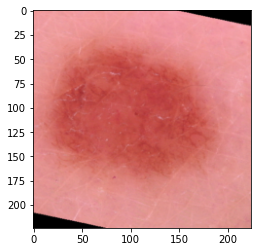

In [6]:
#visualising the images
images, labels = next(iter(trainloader))
print(images[0].numpy().shape)
img = images[5].numpy().transpose(1,2,0)

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img = std * img + mean
img = np.clip(img, 0, 1)
plt.imshow(img)

print(labels[5])

In [8]:
#downloading the pretrained model
model = models.densenet121(pretrained=False)
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [9]:
# We will keep the features part static and update the classifier part

#Freeze our feature parameters
for param in model.parameters():
    param.requires_grad = False
  
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(1024, 500)),
    ('dropout1', nn.Dropout(0.2)),
    ('relu1', nn.ReLU()),
    ('fc2', nn.Linear(500, 2)),
    ('output', nn.LogSoftmax(dim=1))
]))

model.classifier = classifier

In [10]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#moving the model to 'cuda' if available else 'cpu'
model.to(device)
torch.cuda.is_available()

True

In [11]:
#defining the function for validating the model
def validation(model, testloader, criterion):
    accuracy = 0
    test_loss = 0
    
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        #images = images.view(images.shape[0], -1)
        
        logits = model(images)
        ps = torch.exp(logits)
        
        test_loss += criterion(logits, labels).item()
        #print('*'*20)
        #print(logits[:10])
        #print(labels[:10])
        #print('*'*20)
        top_k, top_class  = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    
    return accuracy, test_loss

In [12]:
#defining the function to train the model
def train(model, trainloader, testloader, criterion, optimizer, epochs=5, print_every=1):
    #print('train def')
    training_loss = 0
    steps = 0
    
    for e in range(epochs):
        #print('epoch start')
        model.train()
        
        for images, labels in trainloader:
            #print('images start')
            images, labels = images.to(device), labels.to(device)
            steps += 1
            #images = images.view(images.shape[0], -1)
            optimizer.zero_grad()
            
            #print('optimizer zero grad')

            logits = model(images)
            #print(logits)
            loss = criterion(logits, labels)

            loss.backward()
            optimizer.step()
            
            training_loss += loss.item()
            #print('loss item')
            
            if steps%print_every == 0:
                model.eval()
                accuracy = 0
                test_loss = 0
                with torch.no_grad():
                    accuracy, test_loss = validation(model, testloader, criterion)
                
                print('Epoch {}/{}: '.format(e+1, epochs),
                     'Step: {}: '.format(steps),
                     'Training Loss {:.3f} '.format(training_loss/print_every),
                     'Test Loss {:.3f} '.format(test_loss/len(testloader)),
                     'Test Accuracy {:.3f}'.format(accuracy/len(testloader)))

                training_loss = 0
                model.train()

In [13]:
train(model, trainloader, testloader, criterion, optimizer, 1)

Epoch 1/1:  Step: 1:  Training Loss 0.749  Test Loss 312.603  Test Accuracy 0.802
Epoch 1/1:  Step: 2:  Training Loss 176.966  Test Loss 18.591  Test Accuracy 0.802
Epoch 1/1:  Step: 3:  Training Loss 36.977  Test Loss 169.526  Test Accuracy 0.198
Epoch 1/1:  Step: 4:  Training Loss 274.402  Test Loss 88.796  Test Accuracy 0.198
Epoch 1/1:  Step: 5:  Training Loss 184.074  Test Loss 23.013  Test Accuracy 0.198
Epoch 1/1:  Step: 6:  Training Loss 53.863  Test Loss 8.689  Test Accuracy 0.802
Epoch 1/1:  Step: 7:  Training Loss 8.602  Test Loss 15.703  Test Accuracy 0.803
Epoch 1/1:  Step: 8:  Training Loss 21.057  Test Loss 20.035  Test Accuracy 0.803
Epoch 1/1:  Step: 9:  Training Loss 17.043  Test Loss 22.821  Test Accuracy 0.802
Epoch 1/1:  Step: 10:  Training Loss 55.403  Test Loss 20.724  Test Accuracy 0.802
Epoch 1/1:  Step: 11:  Training Loss 25.419  Test Loss 17.606  Test Accuracy 0.803
Epoch 1/1:  Step: 12:  Training Loss 39.861  Test Loss 12.829  Test Accuracy 0.803
Epoch 1/1: 

Epoch 1/1:  Step: 102:  Training Loss 0.364  Test Loss 0.497  Test Accuracy 0.802
Epoch 1/1:  Step: 103:  Training Loss 0.526  Test Loss 0.497  Test Accuracy 0.803
Epoch 1/1:  Step: 104:  Training Loss 0.399  Test Loss 0.497  Test Accuracy 0.803
Epoch 1/1:  Step: 105:  Training Loss 0.396  Test Loss 0.497  Test Accuracy 0.802
Epoch 1/1:  Step: 106:  Training Loss 0.438  Test Loss 0.497  Test Accuracy 0.802
Epoch 1/1:  Step: 107:  Training Loss 0.436  Test Loss 0.498  Test Accuracy 0.803
Epoch 1/1:  Step: 108:  Training Loss 0.672  Test Loss 0.498  Test Accuracy 0.802
Epoch 1/1:  Step: 109:  Training Loss 0.531  Test Loss 0.499  Test Accuracy 0.802
Epoch 1/1:  Step: 110:  Training Loss 0.580  Test Loss 0.499  Test Accuracy 0.802
Epoch 1/1:  Step: 111:  Training Loss 0.483  Test Loss 0.499  Test Accuracy 0.802
Epoch 1/1:  Step: 112:  Training Loss 0.581  Test Loss 0.499  Test Accuracy 0.802
Epoch 1/1:  Step: 113:  Training Loss 0.581  Test Loss 0.498  Test Accuracy 0.802
Epoch 1/1:  Step

Epoch 1/1:  Step: 202:  Training Loss 0.528  Test Loss 0.497  Test Accuracy 0.803
Epoch 1/1:  Step: 203:  Training Loss 0.437  Test Loss 0.498  Test Accuracy 0.802
Epoch 1/1:  Step: 204:  Training Loss 0.575  Test Loss 0.497  Test Accuracy 0.802
Epoch 1/1:  Step: 205:  Training Loss 0.668  Test Loss 0.497  Test Accuracy 0.802
Epoch 1/1:  Step: 206:  Training Loss 0.345  Test Loss 2.726  Test Accuracy 0.803
Epoch 1/1:  Step: 207:  Training Loss 3.198  Test Loss 0.497  Test Accuracy 0.802
Epoch 1/1:  Step: 208:  Training Loss 0.572  Test Loss 0.497  Test Accuracy 0.802
Epoch 1/1:  Step: 209:  Training Loss 0.570  Test Loss 0.497  Test Accuracy 0.802
Epoch 1/1:  Step: 210:  Training Loss 0.568  Test Loss 0.498  Test Accuracy 0.802
Epoch 1/1:  Step: 211:  Training Loss 0.443  Test Loss 0.498  Test Accuracy 0.802
Epoch 1/1:  Step: 212:  Training Loss 0.445  Test Loss 0.499  Test Accuracy 0.802
Epoch 1/1:  Step: 213:  Training Loss 0.446  Test Loss 0.499  Test Accuracy 0.802
Epoch 1/1:  Step

In [15]:
checkpoint = {
    'input_size': 1024,
    'output_size': 2,
    'hidden_size': [500],
    'state_dict': model.state_dict()
             }
torch.save(checkpoint, 'data/checkpoint_1.pth')

Probability of Cat:0.20889750123023987
Probability of Dog:0.7911025285720825

Actual Output: Cat


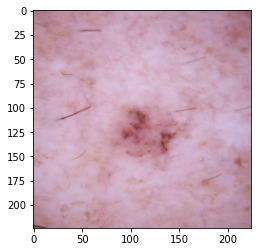

In [24]:
#visualising the trained model
images, labels = next(iter(testloader))
images = images.to(device)

logits = model(images[0].view(-1, 3, 224, 224))
output = torch.exp(logits)

img = images[0].cpu().numpy().transpose(1,2,0)

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img = std * img + mean
img = np.clip(img, 0, 1)
plt.imshow(img)

print('Probability of Cat:{}\nProbability of Dog:{}\n'.format(output[0][0], output[0][1]))
if labels[0].item()==0:
  print('Actual Output: Cat')
else:
  print('Actual Output: Dog')